In [1]:
# Install matplotlib using:
'''
conda install -c conda-forge ipympl
conda install nodejs
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install jupyter-matplotlib
'''
import math

import matplotlib
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from helpers import *
%reload_ext autoreload
%autoreload 2

In [2]:
ring = Study("/maci_data/binary_files/95")

In [3]:
mobile = Study("/maci_data/binary_files/99")

In [5]:
def get_profiling_info(df):
    df = df.loc[(df["level"] != "DEBUG")]
    df.loc[df["msg"].str.startswith("Server is not capable to execute the job."), "msg"] = "-Transmission- Server is not capable to execute the job."
    df.loc[df["msg"].str.startswith("Could not find any"), "msg"] = "-End- Could not find any"
    
    df = df.loc[df.apply(lambda row: row['msg'].startswith("-"), axis=1)]
    df["status"] = df["msg"].str.split('-').str.get(1)
    df.loc[df["msg"].str.startswith("-End- Finished RPC"), "status"] = "Success"
    df = df.sort_values(['job', 'dt'], ascending=True)

    for job, _ in list(df.groupby(["job"])):  
        df.loc[df["job"] == job, "start"] = df[df["job"] == job]["dt"]
        df.loc[df["job"] == job, "end"] = df[df["job"] == job]["dt"].shift(-1)
    
    df["duration"] = df["end"] - df["start"]
    
    return df

In [6]:
c0 = matplotlib.cm.get_cmap("plasma")(20)
c1 = matplotlib.cm.get_cmap("plasma")(180)
c2 = matplotlib.cm.get_cmap("plasma")(250)
colors = (c0, c1, c2)

def as_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(*[int(c*255) for c in rgb[:3]])

print([as_hex(c) for c in colors])

['#380499', '#f2854a', '#f2f026']


In [72]:
PROFILING_COLORS = {"Runtime": "C3", "Transmission": "C0", "Execution": "C2", "Success": "C1", "End":"C8"}
PROFILING_HATCHES = {"Runtime": "", "Transmission": "//", "Execution": "\\\\\\\\", "Success": "", "End":"++"}
TEXT_PADDING = 0.15

WORKER_STRINGS = {"first":"Recent", "random":"Random", "best":"Best", "probabilistic":"Spread"}
CAPS_STRINGS = {"every":"Equal", "some":"Differing"}
SCN_STRINGS = {"aot": "AoT", "jit": "JiT"}

def profiling_description(row):
    scn = SCN_STRINGS[row["scn"]]
    worker = WORKER_STRINGS[row["worker"]]
    cap = CAPS_STRINGS[row["cap"]]
    clients = row["clients"]
    movement = row["movement"]
    simInstanceId = row["simInstanceId"]
    return "{scn}, {worker}, clients: {clients}, movement {movement} (sim {simInstanceId})".format(**locals())

def profiling_plot(df, xlim=(0, 500), print_nodes=True):
    profiling_info = get_profiling_info(df).sort_values(["scn", "worker", "clients", "movement"])
    
    profiling_info = profiling_info[profiling_info['clients'] == 1]
    
    jobs = profiling_info.groupby("job", sort=False).first().index
    
    fig, axs = plt.subplots(nrows=len(jobs), figsize=(10, len(jobs)/5), dpi=100)
    axs = axs if len(jobs) > 1 else [axs]
    
    for num, job in enumerate(jobs):
        instance_profiling = profiling_info[profiling_info["job"] == job]

        # setup basic graph
        ax = axs[num]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(xlim)
        ax.set_ylim((0, 1))
        ax.text(xlim[1] + 1, TEXT_PADDING, profiling_description(instance_profiling.iloc[0]))
        
        # plot the phases
        for _, row in instance_profiling.iterrows():
            if row["status"] not in PROFILING_COLORS:
                continue
            
            ax.axvspan(row["start"], row["end"], facecolor=PROFILING_COLORS[row["status"]], alpha=0.4, hatch=PROFILING_HATCHES[row["status"]])
                                     
            if print_nodes and (row["status"] == "Execution"):
                ax.annotate(row["node"], xy=(row["start"], TEXT_PADDING))
        
        # plot failure indicator
        last = instance_profiling.iloc[-1]
        ax.annotate(last["status"], xy=(last["start"], TEXT_PADDING))
    
    
    xticks_from_to =[math.ceil(val/10) * 10 for val in xlim]
    axs[-1].set_xticks(range(*xticks_from_to, 10))
    axs[-1].set_xlabel("Time (s)")
        
    return fig
    
RING_RUNS = [
    "jit-first-every-4", 
    "jit-random-every-7", 
    "jit-best-every-2", 
    "jit-probabilistic-every-2", 
    "aot-best-every-1", 
    "jit-first-some-1", 
    "jit-random-some-3", 
    "jit-best-some-2", 
    "jit-probabilistic-some-1", 
    "aot-best-some-1",
]

#profiling_plot(mobile.dtnrpc, print_nodes=False)#.savefig("profiling-ring.pdf", bbox_inches='tight')

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


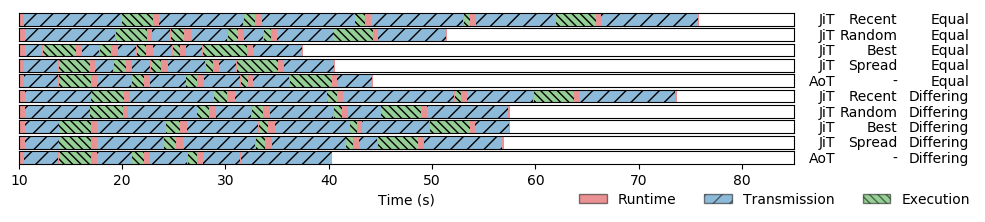

In [85]:
def profiling_description(row):
    worker = WORKER_STRINGS[row["worker"]]
    cap = CAPS_STRINGS[row["cap"]]
    scn = SCN_STRINGS[row["scn"]]
    return "{scn}, {cap}, {worker}".format(**locals())

def profiling_plot2(df, xlim=(10, 85), runs=None, print_nodes=True, alpha=0.5):
    profiling_info = get_profiling_info(df)
    
    if runs is None:
        runs = profiling_info[profiling_info["clients"] == 1].groupby("desc").first().index
    
    fig, axs = plt.subplots(nrows=len(runs), figsize=(10, len(runs)/5), dpi=100)
    axs = axs if len(runs) > 1 else [axs]
    
    for num, desc in enumerate(runs):
        instance_profiling = profiling_info[profiling_info["desc"] == desc]
        other_instances = profiling_info[
            (profiling_info["scn"] == instance_profiling.iloc[0]["scn"]) &
            (profiling_info["worker"] == instance_profiling.iloc[0]["worker"]) &
            (profiling_info["cap"] == instance_profiling.iloc[0]["cap"])
        ].groupby("desc").last()
        
        std_dev = other_instances["dt"].std()
        means = other_instances["dt"].mean()
        
        # setup basic graph
        ax = axs[num]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(xlim)
        ax.set_ylim((0, 1))
        ax.text(xlim[1] + 4, TEXT_PADDING, SCN_STRINGS[instance_profiling.iloc[0]["scn"]], horizontalalignment="right")
        if instance_profiling.iloc[0]["scn"] == "jit":
            ax.text(xlim[1] + 10, TEXT_PADDING, WORKER_STRINGS[instance_profiling.iloc[0]["worker"]], horizontalalignment="right")
        else:
            ax.text(xlim[1] + 10, TEXT_PADDING, "-", horizontalalignment="right")
        ax.text(xlim[1] + 17, TEXT_PADDING, CAPS_STRINGS[instance_profiling.iloc[0]["cap"]], horizontalalignment="right")
        
        # plot the phases
        for _, row in instance_profiling.iterrows():
            if row["status"] not in PROFILING_COLORS:
                continue
            
            ax.axvspan(row["start"], row["end"], facecolor=PROFILING_COLORS[row["status"]], alpha=alpha, hatch=PROFILING_HATCHES[row["status"]])
                                     
            if print_nodes and (row["status"] == "Execution"):
                ax.annotate(row["node"], xy=(row["start"], TEXT_PADDING))
        
        # plot failure indicator
        last = instance_profiling.iloc[-1]
        #if last["status"] != "Success":
        #    ax.annotate(" !!!", xy=(last["start"], TEXT_PADDING))
        
        # plot mean and stddev
        #ax.plot((means-std_dev, means+std_dev), (0.5, 0.5), color="black", linewidth=1.0)
        #ax.plot((means, means), (0.2, 0.8), color="black", linewidth=1.0)
    
    xticks_from_to =[math.ceil(val/10) * 10 for val in xlim]
    axs[-1].set_xticks(range(*xticks_from_to, 10))
    axs[-1].set_xlabel("Time (s)")
    
    legend_order = ["Runtime", "Transmission", "Execution"]
    custom_legend = [
        axs[-1].bar(0, 0, facecolor=PROFILING_COLORS[state], alpha=alpha, hatch=PROFILING_HATCHES[state], edgecolor="black")
        for state in legend_order]
    axs[-1].legend(custom_legend, legend_order, loc='lower center', ncol=3, bbox_to_anchor=(0.475, -4.30, 1, 0.5), frameon=False)
    
    return fig
    
RING_RUNS = [
    "jit-first-every-4", 
    "jit-random-every-7", 
    "jit-best-every-2", 
    "jit-probabilistic-every-2", 
    "aot-best-every-1", 
    "jit-first-some-1", 
    "jit-random-some-3", 
    "jit-best-some-2", 
    "jit-probabilistic-some-1", 
    "aot-best-some-1",
]

profiling_plot2(ring.dtnrpc, runs=RING_RUNS, print_nodes=False).savefig("profiling-ring.pdf", bbox_inches='tight')
#profiling_plot2(mobile.dtnrpc, print_nodes=True)#.savefig("profiling-ring.pdf", bbox_inches='tight')

In [49]:
# average runtimes (total, decision, transmission, computation )
def runtimes(df, groups=["scn", "worker"]):
    df = df[df["level"] == "INFO"]
    profiling_info = get_profiling_info(df)
    
    times = profiling_info.groupby(["job", "status"]).sum()["duration"].unstack()[["Runtime", "Transmission", "Execution"]]
    configs = profiling_info.groupby(["job"]).last()[["scn", "worker", "cap", "seed", "desc", "simInstanceId", "status"]]
    times = times.join(configs)
    times = times[(times["status"] == "Success") | (times["status"] == "End")]
    
    times_table = times.groupby(groups).mean()
    times_table["Total"] = times_table["Execution"] + times_table["Runtime"] + times_table["Transmission"]
    times_table = times_table[["Execution", "Runtime", "Transmission", "Total"]].round(2)
    
    return times_table
    
        
print("Ring")
ring_times = runtimes(ring.dtnrpc)
display(ring_times)
print(ring_times.to_latex())

print("Mobile")
mobile_times = runtimes(mobile.dtnrpc)
display(mobile_times)
print(mobile_times.loc["jit"].to_latex())

Ring


Execution  Runtime  Transmission  Total
scn worker                                                
aot best                9.95     3.79         20.43  34.17
    first               9.92     3.76         20.47  34.16
    probabilistic       9.94     3.76         20.44  34.13
    random              9.94     3.77         20.42  34.13
jit best               10.02     3.94         23.54  37.49
    first               9.65     3.89         50.94  64.48
    probabilistic       9.95     3.95         24.05  37.94
    random              9.82     3.93         32.60  46.35

\begin{tabular}{llrrrr}
\toprule
    &        &  Execution &  Runtime &  Transmission &  Total \\
scn & worker &            &          &               &        \\
\midrule
aot & best &       9.95 &     3.79 &         20.43 &  34.17 \\
    & first &       9.92 &     3.76 &         20.47 &  34.16 \\
    & probabilistic &       9.94 &     3.76 &         20.44 &  34.13 \\
    & random &       9.94 &     3.77 &         20.42 &  34.13 \\
jit & best &      10.02 &     3.94 &         23.54 &  37.49 \\
    & first &       9.65 &     3.89 &         50.94 &  64.48 \\
    & probabilistic &       9.95 &     3.95 &         24.05 &  37.94 \\
    & random &       9.82 &     3.93 &         32.60 &  46.35 \\
\bottomrule
\end{tabular}

Mobile


Execution  Runtime  Transmission   Total
scn worker                                                 
jit best                8.89     5.20        135.53  149.62
    first               8.70     5.04        269.01  282.75
    probabilistic       8.87     5.11        234.15  248.13
    random              8.90     5.00        254.94  268.84

\begin{tabular}{lrrrr}
\toprule
{} &  Execution &  Runtime &  Transmission &   Total \\
worker        &            &          &               &         \\
\midrule
best          &       8.89 &     5.20 &        135.53 &  149.62 \\
first         &       8.70 &     5.04 &        269.01 &  282.75 \\
probabilistic &       8.87 &     5.11 &        234.15 &  248.13 \\
random        &       8.90 &     5.00 &        254.94 &  268.84 \\
\bottomrule
\end{tabular}



In [65]:
def job_final_states(df):
    prof_info = get_profiling_info(df)
    final_states = prof_info.groupby("job").last()
    #final_states["duration"] = final_states["dt"] - prof_info.groupby("job").first()["dt"]
    return final_states


def job_state_statistics(df, groups=["scn", "worker"]):
    final_states = job_final_states(df).reset_index()
    statistics = final_states[groups+["status", "job"]].groupby(groups + ["status"]).count()
    stats_table = statistics.unstack().fillna(0)
    stats_table.columns.droplevel()
    return stats_table

#display("Ring:")
#display(job_state_statistics(ring.dtnrpc, groups=["scn", "worker"]))

print("Mobile (bigmama)")
mobile_stats = job_state_statistics(mobile.dtnrpc, groups=["scn", "worker", "clients"])
mobile_stats

Mobile (bigmama)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


job                                       
status                       End Execution Runtime Success Transmission
scn worker        clients                                              
jit best          5         18.0       0.0     0.0   107.0          0.0
                  10        69.0       0.0     1.0   169.0         11.0
    first         5         24.0       0.0     0.0   100.0          1.0
                  10       116.0       1.0     0.0   117.0         16.0
    probabilistic 5         17.0       0.0     0.0   107.0          1.0
                  10        67.0       2.0     0.0   171.0         10.0
    random        5         35.0       0.0     0.0    88.0          2.0
                  10       101.0       0.0     0.0   123.0         26.0

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


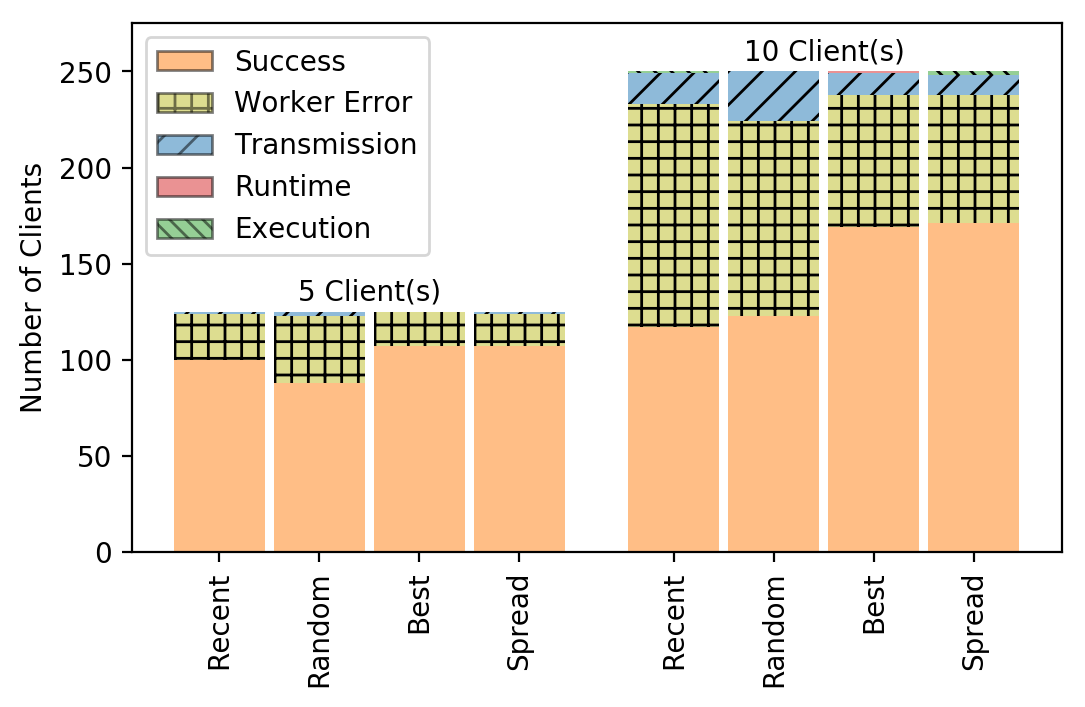

In [79]:
from matplotlib.patches import Patch

def plot_job_state_statistics(df, alpha=0.5):
    stats = job_state_statistics(df[df["scn"] == "jit"], groups=["clients", "worker", ])
    stats.columns = stats.columns.droplevel()
    
    clients_order = [1, 5, 10]
    worker_order = ["first", "random", "best", "probabilistic"]
    state_order = ["Success", "End", "Transmission", "Runtime", "Execution"]
    state_names = ["Success", "Worker Error", "Transmission", "Runtime", "Execution"]
    
    fig, ax = plt.subplots(dpi=200, figsize=(6, 3.5))
    width = 0.2
    inner_padding = 0.02
    text_padding = 10
    groups_pos = [(width+inner_padding)*i for i in range(len(worker_order))]
    xticks = []
    
    for c_num, (c_name, c_data) in enumerate(stats.groupby("clients")):
        stack_height = c_data.iloc[0].sum()
        ax.text(c_num + (1.5 * (width+inner_padding)), stack_height + text_padding, "{} Client(s)".format(c_name), horizontalalignment='center', verticalalignment='center')#, transform=ax.transAxes)
        
        positions = [c_num + p for p in groups_pos]
        xticks += positions
        heights = len(worker_order) * [0.0]

        # sort by worker_order: lambda x: worker_order.index(x[0])
        c_data.index = c_data.index.droplevel()
        c_data["worker"] = c_data.index
        c_data.index = [worker_order.index(worker) for worker in c_data["worker"]]
        c_data = c_data.sort_index()
        
        # iterate through states, plot bar and save heights
        for state in state_order:
            try:
                ax.bar(positions, c_data[state].values, width, facecolor=PROFILING_COLORS[state], hatch=PROFILING_HATCHES[state], alpha=alpha, bottom=heights)
                heights = [old + val for old, val in zip(heights, c_data[state].values)]
            except KeyError:
                pass
    
    ax.set_xticks(xticks)
    ax.set_xticklabels([WORKER_STRINGS[worker] for worker in len(clients_order)*worker_order], rotation=90)
    ax.set_ylim((0, stack_height*1.1))

    custom_legend = [ax.bar([1], [0], facecolor=PROFILING_COLORS[state], edgecolor="black", hatch=PROFILING_HATCHES[state], alpha=alpha) for state in state_order]
    ax.legend(custom_legend, state_names)
    ax.autoscale_view()
    ax.set_ylabel("Number of Clients")
    
    return fig


plot_job_state_statistics(mobile.dtnrpc).savefig("mobile-final-states.pdf", bbox_inches='tight')


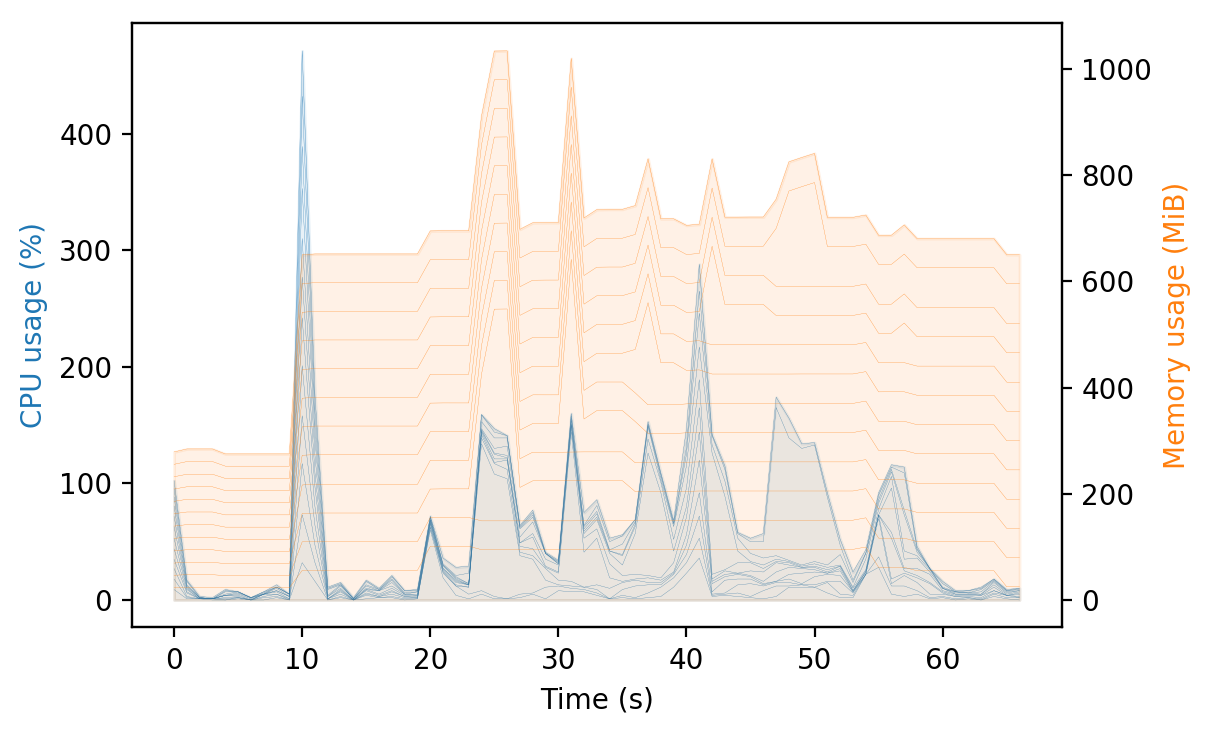

In [12]:
def plot_load(experiment):
    fig, ax_cpu = plt.subplots(dpi=200)
    loads_list = list(experiment.pidstat.groupby("node"))
    ax_mem = ax_cpu.twinx()
    
    cumulated = None
    
    for node, loads in sorted(loads_list, key=lambda tup: int(tup[0][1:])):
        #node_load_sum = loads[
            #    (loads["Command"] == "servald") |
            #    (loads["Command"] == "mogrify") |
            #    (loads["Command"] == "shrink")  |
            #    (loads["Command"] == "python")  |
            #    (loads["Command"] == "python3") ].groupby(["dt"]).sum()
        
        node_load_sum = loads.groupby(["dt"]).sum()
        node_load_sum["mRSS"] = node_load_sum["RSS"] / 1024

        if cumulated is None:
            cumulated = [node_load_sum[["%CPU"]], node_load_sum[["mRSS"]]]
        else:
            cumulated[0] += node_load_sum[["%CPU"]]
            cumulated[1] += node_load_sum[["mRSS"]]
        
        ax_cpu.plot(cumulated[0], color="C0", linewidth=0.1)
        ax_mem.plot(cumulated[1], color="C1", linewidth=0.1)
    
    ax_cpu.fill_between(cumulated[0].index, 0, cumulated[0]["%CPU"], alpha=0.1, color="C0")
    ax_mem.fill_between(cumulated[1].index, 0, cumulated[1]["mRSS"], alpha=0.1, color="C1")
    
    ax_cpu.set_xlabel("Time (s)")
    ax_cpu.set_ylabel("CPU usage (%)", color="C0")
    ax_mem.set_ylabel("Memory usage (MiB)", color="C1")
    
    return fig
    

plot_load(ring.experiments[383]).savefig("load.pdf", bbox_inches='tight')

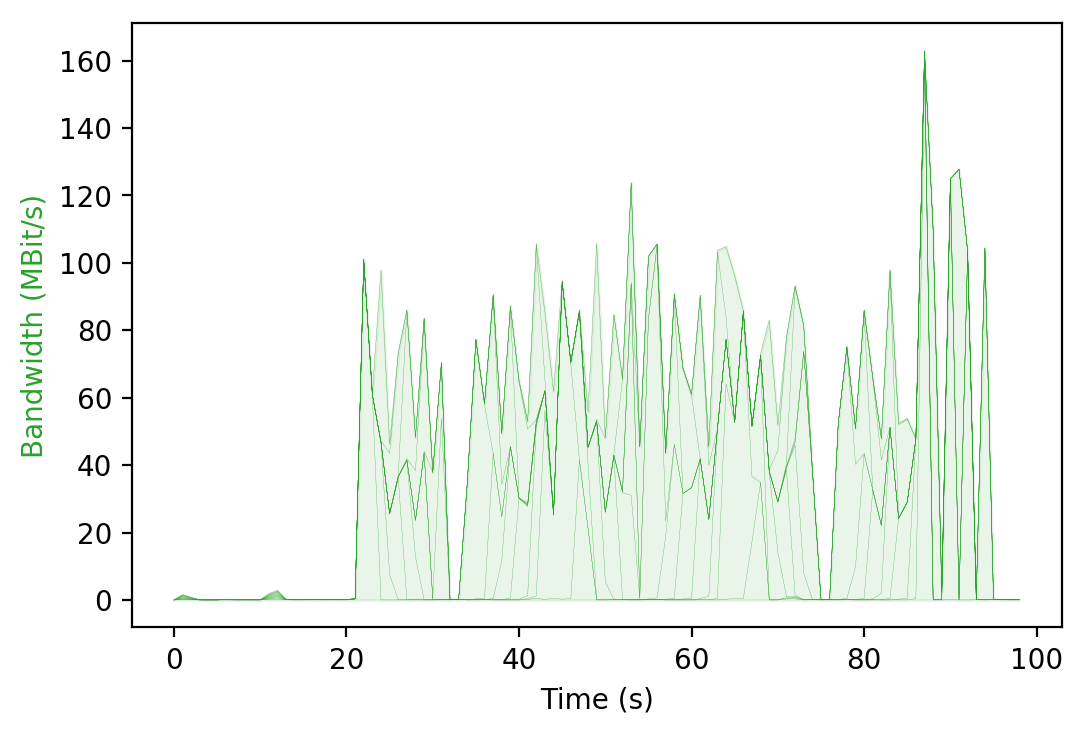

In [13]:
def plot_bandwidth(ex):
    bw_list = list(ex.bwm[ex.bwm["iface"] == "total"].groupby("node"))
    
    fig, ax = plt.subplots(dpi=200)
    
    cumulated = None
    
    for node, node_bw in sorted(bw_list, key=lambda tup: int(tup[0][1:])):
        node_bw_sum = node_bw.groupby(["dt"]).sum()
        
        if cumulated is None:
            cumulated = node_bw_sum[["bytes_out/s"]] / 1024 / 1024 * 8
        else:
            cumulated += node_bw_sum[["bytes_out/s"]] / 1024 / 1024 * 8
        
        ax.plot(cumulated, color="C2", linewidth=0.1)
        
    ax.fill_between(range(len(cumulated.index)), 0, cumulated["bytes_out/s"], alpha=0.1, color="C2")
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Bandwidth (MBit/s)", color="C2")
    
    
plot_bandwidth(ring.experiments[0])

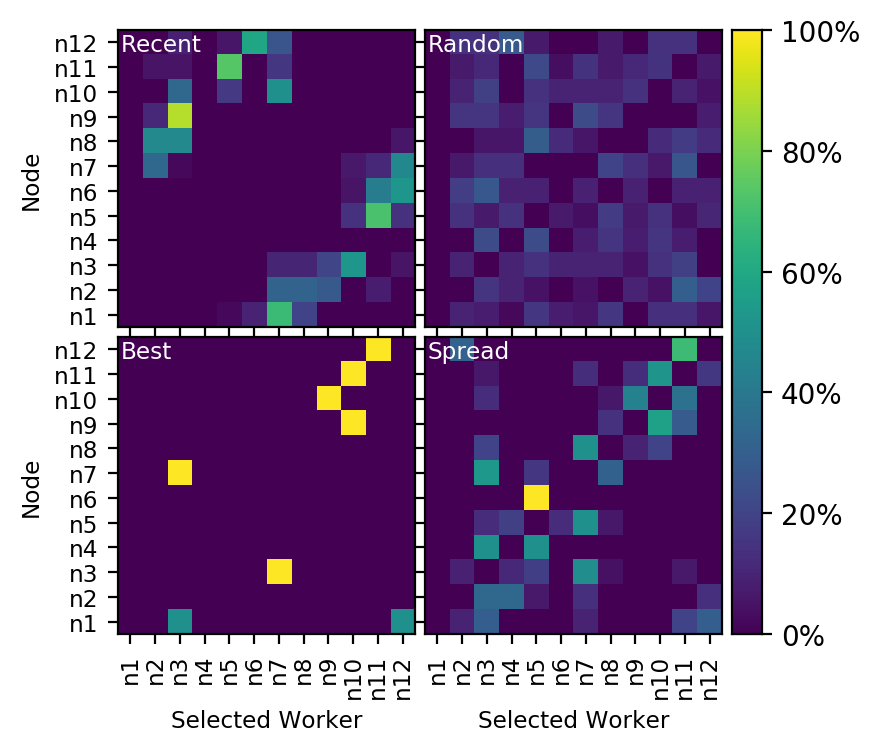

In [14]:
from mpl_toolkits.axes_grid1 import AxesGrid

def plot_social_heatmap(study, node_count=12):
    df = study.dtnrpc

    df = df[
        (df["scn"] == "jit") &
        (df["msg"].str.startswith("Using server"))
    ].copy()
    df["server"] = df["msg"].str.slice(13, 13+64)
    
    sids = study.sids.copy()
    sids = sids.set_index(["simInstanceId", "sid"])
    df = df.join(sids[["node"]], on=["simInstanceId", "server"], rsuffix="_next")
    
    node_order_x = ["n{}".format(i+1) for i in range(node_count)]
    node_order_y = list(reversed(node_order_x))
    
    method_groups = df.groupby("worker")

    matrixes = []
    
    for method, method_df in method_groups:

        method_df = method_df.groupby(["node", "node_next"])[["index"]].count()
        worker_matrix = method_df.unstack(level=-1)["index"]
        worker_matrix = worker_matrix.reindex(node_order_x, axis=1)
        worker_matrix = worker_matrix.reindex(node_order_y, axis=0)
        worker_matrix = worker_matrix.fillna(0.0)
        
        matrixes.append((method, worker_matrix))
        
    matrixes = sorted(matrixes, key=lambda x: ["first", "random", "best", "probabilistic"].index(x[0])) 
        
    
    fig = plt.figure(dpi=200)
    grid = AxesGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.05, label_mode="L", cbar_location="right", cbar_mode="single")
    
    
    for (method, worker_matrix), ax in zip(matrixes, grid):
        
        # plot should show the empirical probability of the node selecting another node
        worker_matrix = worker_matrix.div(worker_matrix.sum(axis=1), axis=0)
        worker_matrix = worker_matrix.fillna(0.0)
        
        im = ax.imshow(worker_matrix, vmax=1.0)

        ax.set_xlabel("Selected Worker", size="small")
        ax.set_xticks(range(worker_matrix.columns.size))
        ax.set_xticklabels(worker_matrix.columns, size='small', rotation=90)
    
        ax.set_ylabel("Node", size="small")
        ax.set_yticks(range(worker_matrix.index.size))
        ax.set_yticklabels(worker_matrix.index, size='small')
        
        ax.text(-0.4, (0.04*node_count)-0.15, WORKER_STRINGS[method], color="white", size='small')
    
    
    cbar_ticks = np.linspace(0.0, 1.0, num=6)
    cbar = grid.cbar_axes[0].colorbar(im)
    cbar.ax.set_yticklabels(["{:.0f}%".format(x*100) for x in cbar_ticks])
    
    return fig
    

plot_social_heatmap(ring).savefig("heatmap-ring.pdf", bbox_inches='tight')

#plot_social_heatmap(mobile, node_count=30)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


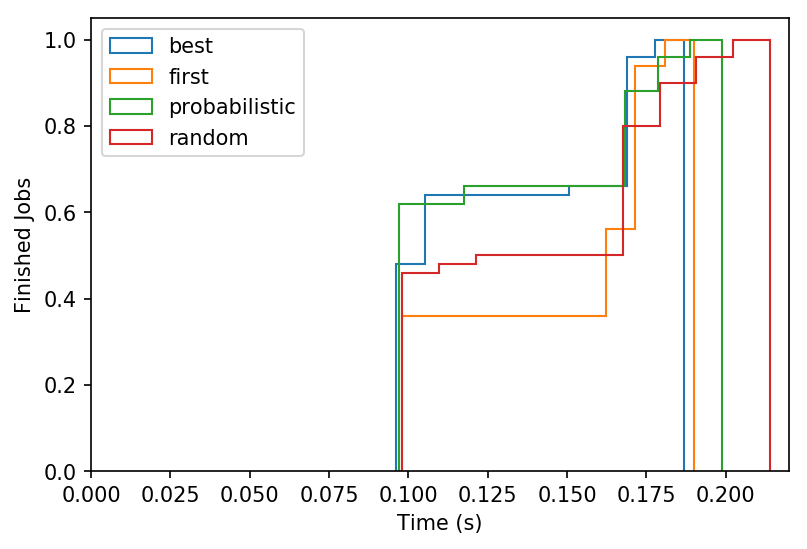

In [15]:
def plot_job_runtimes_cdf(study, groups=["worker"]):
    jobs = job_final_states(study.dtnrpc[study.dtnrpc["scn"] == "jit"])
    jobs = jobs[jobs["status"] == "Success"]
    
    fig, ax = plt.subplots(dpi=150)

    for group, jobs in list(jobs.groupby(groups)):
        n, bins, patches = ax.hist(jobs["duration"], histtype='step', cumulative=True, density=True, label=group)

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Finished Jobs')
    ax.set_xlim(0, ax.get_xlim()[1])
    ax.legend()

    
plot_job_runtimes_cdf(ring)
#plot_job_runtimes_cdf(mobile)